In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import gridspec
from keras.datasets import boston_housing
from sklearn import preprocessing as p
from sklearn import model_selection as mdl
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
# Visualization settings
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams['ytick.major.pad']='1'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams["axes.labelsize"] = 15

# Print Settings
pd.set_option('display.width', 2000)
pd.set_option('precision', 3)
np.set_printoptions(precision=3, suppress=True)

## The Dataset
Boston Housing prices, columns are as follows:

    CRIM - per capita crime rate by town
    ZN -proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per 10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - Percent lower status of the population
    MEDV - Median value of owner-occupied homes in 1000's

In [3]:
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

In [7]:
x_headers = ["CRIM", "ZN","INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]
y_headers = ["MEDV"]

In [8]:
trainDF = pd.DataFrame(x_train, columns=x_headers)
trainDF['MEDV'] = y_train
trainDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.232,0.0,8.14,0.0,0.538,6.142,91.7,3.977,4.0,307.0,21.0,396.90,18.72,15.2
1,0.022,82.5,2.03,0.0,0.415,7.610,15.7,6.270,2.0,348.0,14.7,395.38,3.11,42.3
2,4.898,0.0,18.10,0.0,0.631,4.970,100.0,1.333,24.0,666.0,20.2,375.52,3.26,50.0
3,0.040,0.0,5.19,0.0,0.515,6.037,34.5,5.985,5.0,224.0,20.2,396.90,8.01,21.1
4,3.693,0.0,18.10,0.0,0.713,6.376,88.4,2.567,24.0,666.0,20.2,391.43,14.65,17.7


In [9]:
print('Number of zero values per column:\n')
_ = [print(h, end='\t') for h in x_headers]
print()
for h in x_headers:
    print((trainDF[h] == 0).sum(), end='\t')

Number of zero values per column:

CRIM	ZN	INDUS	CHAS	NOX	RM	AGE	DIS	RAD	TAX	PTRATIO	B	LSTAT	
0	300	0	379	0	0	0	0	0	0	0	0	0	

## Observations
 - Whether a house borders the charles river is a boolean value, and most are set to 0.
 - The proportion of residential land zoned for lots over 25,000sq-ft is usually none of it.

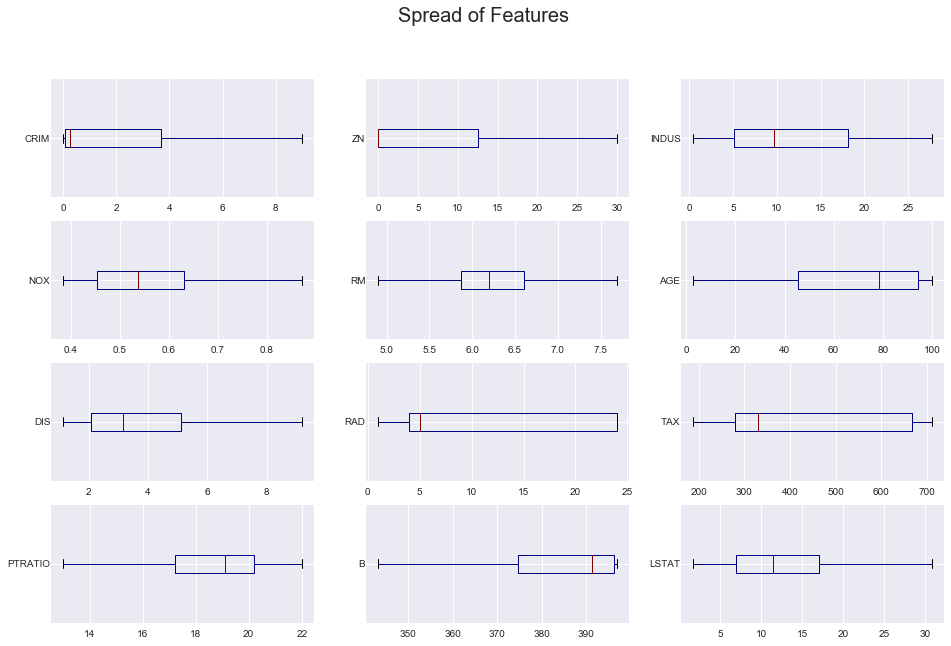

In [63]:
fig, axes= plt.subplots(4, 3)
_ = pd.DataFrame(x_train, columns=x_headers).drop('CHAS',1).plot(kind='box',
                                                                 subplots=True, 
                                                                 ax=axes, 
                                                                 showfliers=False, 
                                                                 vert=False,
                                                                 colormap='jet')

_ = fig.suptitle("Spread of Features",fontsize=20)

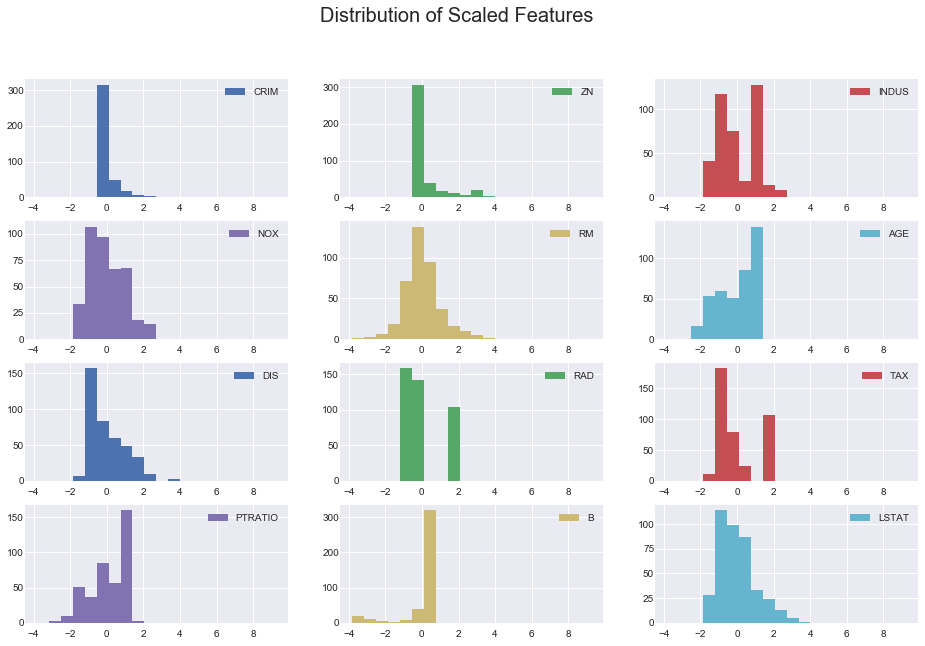

In [62]:
fig, axes= plt.subplots(4, 3)
_ = pd.DataFrame(p.scale(x_train), columns=x_headers).drop('CHAS',1).plot(kind='hist',
                                                                          bins=20,
                                                                          subplots=True, 
                                                                          ax=axes)

_ = fig.suptitle("Distribution of Scaled Features",fontsize=20)

for ax in axes.flat: ax.set_ylabel('')

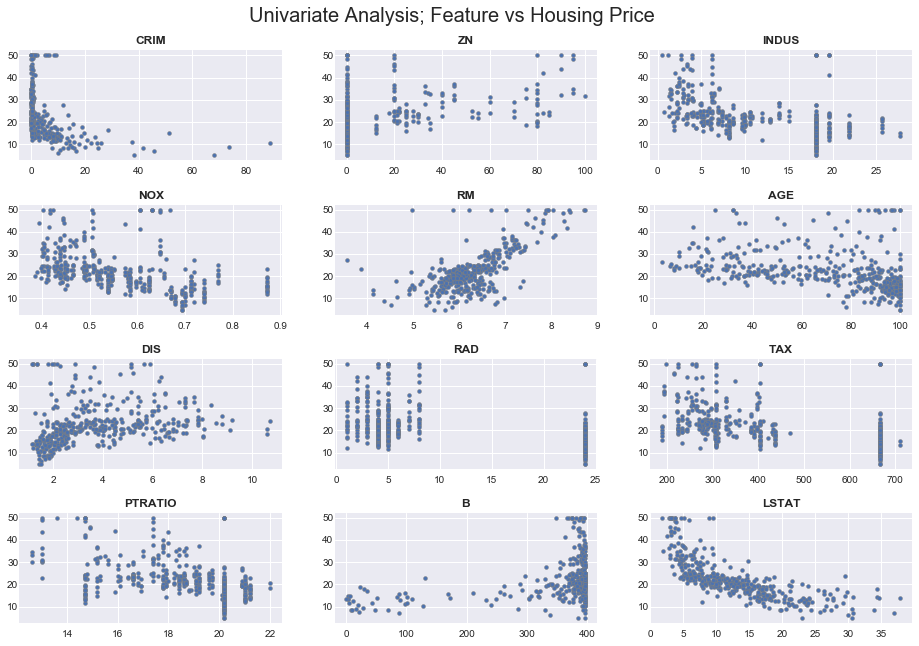

In [106]:
fig, axes= plt.subplots(4, 3)
_ = fig.suptitle('Univariate Analysis; Feature vs Housing Price', fontsize=20)

df = pd.DataFrame(x_train, columns=x_headers).drop('CHAS',1)
headers = df.columns
i = 0

for ax in axes.flat:
    ax.set_title(headers[i], fontweight='bold', fontsize=12)
    ax.scatter(df.iloc[:,i], y_train, s=15, marker='o', edgecolor='grey', linewidth='0.5')
    i += 1
    
plt.subplots_adjust(top=0.92, hspace=0.4)

## Observations
- The only feature with a nicely distributed range of values is average number of rooms. The rest seem skewed
- Property Tax rate looks nearly categorical
- accessibility to highways looks pretty categorical
- Room count is correlated to housing price
- Percent lower status of the population is inversely correlated to housing price

## Preprocessing Techniques


### Why Scale?
Most predictive models work best under the assumption that the data is centered about zero, and that all features have an equal magnitude of variance. This equal variance allows the cost function of the model to weight all features equally. If some features are more important than others, they can be scaled differently so that the features variability contributes more to the cost function. Because of this, it's a good idea to translate the dataset so it is centered around zero and scale each feature to have a unit standard deviation. 

It's worth noting that some models, like Decision Tree algorithms are robust to different scales.


### Are any two features highly correlated?

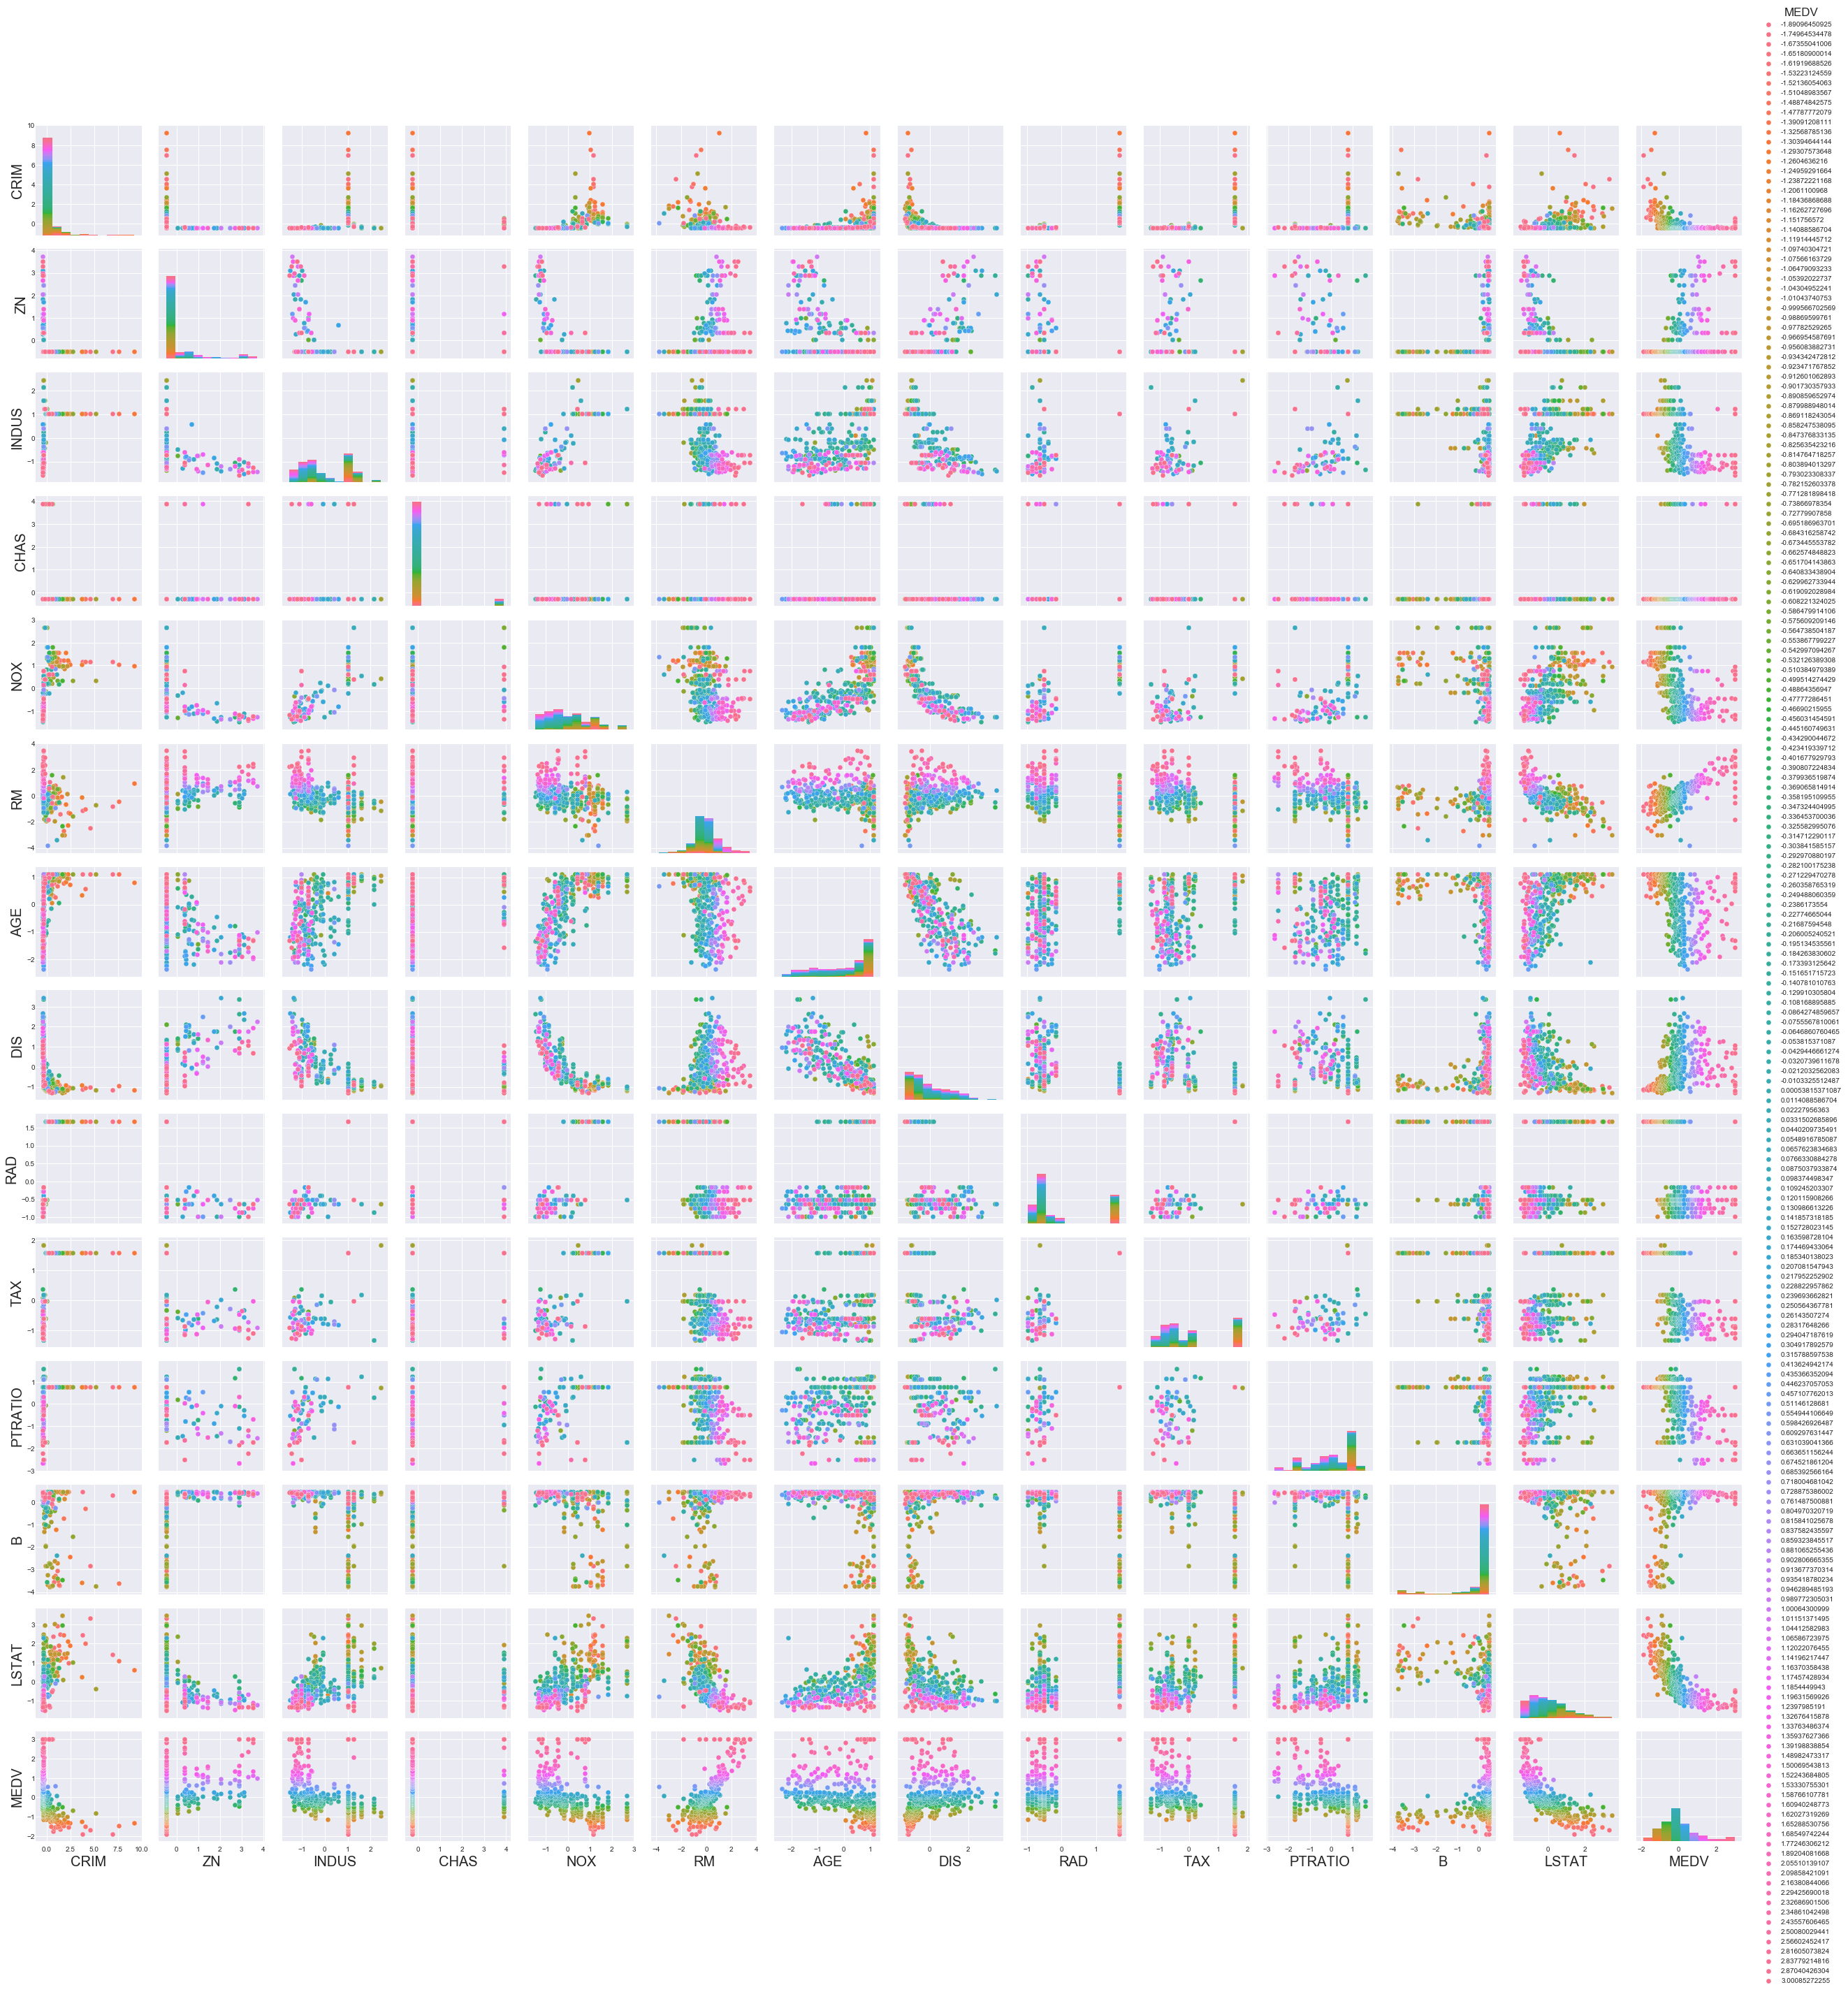

In [78]:
scaled_trainDF = pd.DataFrame(p.scale(trainDF), columns=(x_headers + y_headers))
_ = sns.pairplot(
    data = scaled_trainDF,
    vars=scaled_trainDF.columns,
    hue='MEDV')

<IPython.core.display.Javascript object>


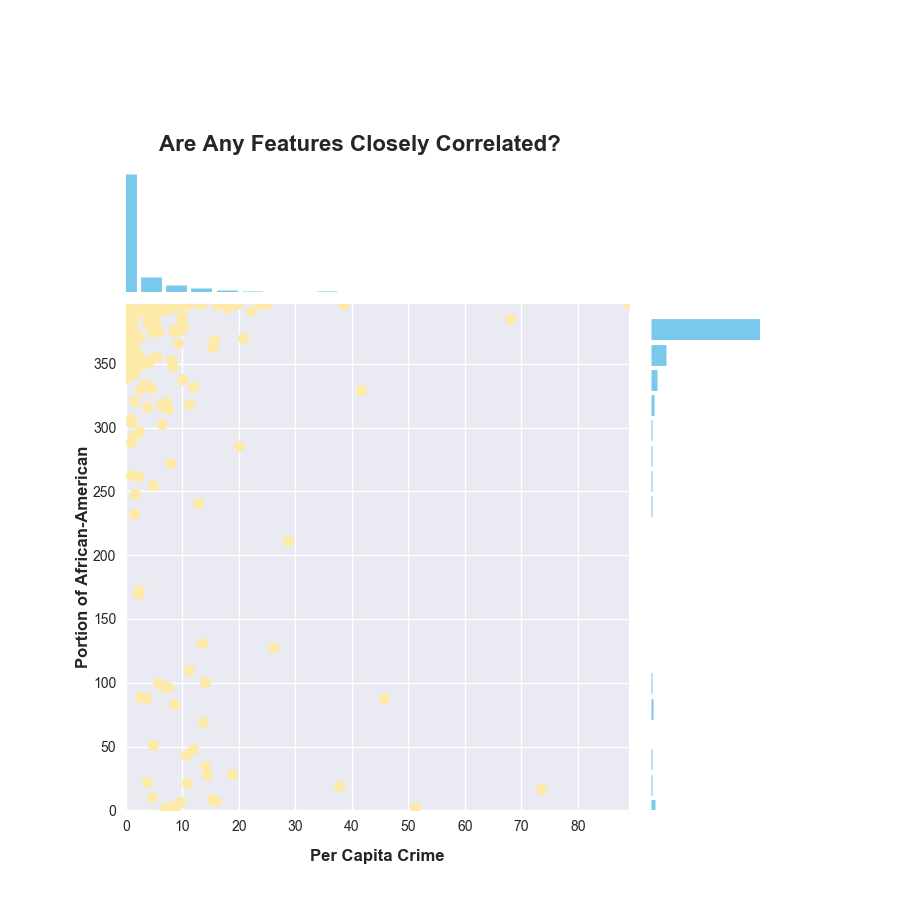

In [4]:
%reload_ext autoreload
from dataviz import graph_animator 
from matplotlib import rc
from IPython.display import HTML
%matplotlib notebook

rc('animation', html='html5')
viz = graph_animator()

## Pre-step to Model building, visualization
Just to reduce the visualization code in my model training, I'm going to put together a plotting helper.

In [ ]:
class plot_handler():
    """
    ' Plot handler to help me control the shape of my subplots better.
    """
    def __init__(self, plot_rows, plot_cols):
        self.rows = plot_rows
        self.cols = plot_cols
        self.fig = plt.figure(facecolor='white', figsize=(16,16))
        self.grid = gridspec.GridSpec(self.rows, self.cols)
        
        self.grid.update(left=0.1, 
                         right=0.9, 
                         wspace=0.2,
                         hspace=.15,
                         top=0.9, 
                         bottom=0.1)

        self.ax = {}
        self.xlimit = None
        self.ylimit = None
        
    def __call__(self):
        plt.show
        
    def add_plot(self, top, bottom, left, right, name, title):
        self.ax[name] = self.fig.add_subplot(self.grid[top:bottom, left:right])
        self.ax[name].set_title(title,fontweight="bold", size=14)
        
        # self.ax[name].set_xticks([])
        # self.ax[name].set_yticks([])
    def plot_exists(self, name):
        if name in self.ax:
            return True
        else:
            return False
        
    def plot(self, data, plot_name, ylim=None, c='b', alpha=1.0):
        self.ax[plot_name].plot(data,  '-', c=c, alpha=alpha)
        
        if not ylim:
            self.ax[plot_name].set_ylim([0,ylim])
        

# Creating Model
The chosen model architecture for this problem was a two layer neural network with a mean squared error loss function. Below is the implementation, which includes the creation of the architecture, calculation of the loss function, as well as the training algorithm.

In [19]:
# Construct simple model
def base_model():
    model = Sequential()
    
    model.add(Dense(units=64, 
                    input_dim=num_features,
                    kernel_initializer='normal',
                    activation='relu',
                    use_bias=True))
    model.add(Dense(units=64, 
                    kernel_initializer='normal',
                    activation='relu',
                    use_bias=True))
    model.add(Dense(units=1, 
                    kernel_initializer='normal',
                    activation='linear',
                    use_bias=True))
    model.compile(loss='mean_squared_error', 
                  optimizer='sgd', 
                  metrics=['mae'])

    return model


class NeuralNetwork():
    """
    Two (hidden) layer neural network model. 
    First and second layer contain the same number of hidden units
    """
    def __init__(self, input_dim, units, std=0.0001):
        self.params = {}
        self.input_dim = input_dim
        
        self.params['W1'] = np.random.rand(self.input_dim, units)
        self.params['W1'] *= std
        self.params['b1'] = np.zeros((units))
        
        self.params['W2'] = np.random.rand(units, units)
        self.params['W2'] *= std * 10  # Compensate for vanishing gradients
        self.params['b2'] = np.zeros((units))
        
        self.params['W3'] = np.random.rand(units, 1)
        self.params['b3'] = np.zeros((1,))
        
    
    def mse_loss(self, x, y=None, drop_p=0.9, reg=0.01, evaluate=False, predict=False):

        # Unpack variables
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']
        N, D = x.shape
    
        ###############################################
        # Forward Pass
        ###############################################
        Fx = None
        
        # First Layer
        x1 = np.dot(x, W1) + b1 
        
        # Activation
        a1 = np.maximum(x1, 0)
        
        # Drop Out
        drop1 = np.random.choice([1,0],size=x1.shape, p=[drop_p, 1-drop_p]) / drop_p
        a1 *= drop1
        
        # Second Layer
        x2 = np.dot(a1, W2) + b2  
        
        # Activation
        a2 = np.maximum(x2, 0)
        
        # Drop Out
        drop2 = np.random.choice([1,0], size=x2.shape, p=[drop_p, 1-drop_p]) / drop_p
        a2 *= drop2
        
        # Final Layer
        x3 = np.dot(a2, W3) + b3
        
        # Output
        Fx = x3
        
        if predict:
            return Fx
        
        # Mean Squared Error Cost Function
        mse_loss = np.sum((Fx - y)**2, axis=0) / N
        mae_loss = np.sum(np.absolute(Fx - y)) / N
        wght_loss = 0.5 * reg * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**3))
        loss = mse_loss + wght_loss
        
        if evaluate:
            return loss, mae_loss, mse_loss, wght_loss
        
        #############################################
        # Backpropagation
        #############################################
        
        grads = {}
        
        # Output
        dFx = 2 * (Fx.copy() - y) / N  # [50, 1]
        
        # Final Layer
        dx3 = np.dot(dFx, W3.T)   
        dW3 = np.dot(x2.T, dFx)
        db3 = np.sum(dFx * N, axis=0)
        
        # Drop Out
        dx3 *= drop2
        
        # activation
        da2 = a2.copy()
        da2[da2 > 0] = 1
        da2[da2 <= 0] = 0
        da2 *= dx3
        
        # Second Layer
        dx2 = np.dot(da2, W2.T)
        dW2 = np.dot(x1.T, da2)
        db2 = np.sum(da2, axis=0)
        
        # Drop out
        dx2 *= drop1
        
        # activation
        da1 = a1.copy()
        da1[da1 > 0] = 1
        da1[da1 < 0] = 0
        da1 *= dx2
        
        # First Layer
        dx1 = np.dot(da1, W1.T) 
        dW1 = np.dot(x.T, da1)
        db1 = np.sum(da1, axis=0)
        
        grads['W3'] = dW3
        grads['b3'] = db3
        grads['W2'] = dW2
        grads['b2'] = db2
        grads['W1'] = dW1
        grads['b1'] = db1
        
        grads['W3'] += dW3 * reg
        grads['W2'] += dW2 * reg
        grads['W1'] += dW1 * reg
        
        return mae_loss, loss, grads
    
    
    def fit(self, X, y, validation_data, epochs=80, 
            learning_rate=1e-3, learning_rate_decay=0.99,
            reg=1e-5, batch_size=50, dropout_val=0.95):
        
        assert type(validation_data) == tuple
        x_val, y_val = validation_data
        
        num_train = X.shape[0]
        iters_per_epoch = max(num_train // batch_size, 1)
        val_acc = 0
        
        loss_history = []
        val_loss_history = []
        mae_history = []
        val_mae_history = []
        
        for e in range(epochs):
            for it in range(iters_per_epoch):
                x_batch = None
                y_batch = None

                batch_indices = np.random.choice(num_train, 
                                                 batch_size, 
                                                 replace=False)

                x_batch = X[batch_indices]
                y_batch = y[batch_indices]

                mae, loss, grads = self.mse_loss(x_batch, 
                                            y_batch, 
                                            drop_p=dropout_val, 
                                            reg=reg)

                val_mae, val_loss, _ = self.mse_loss(x_val, y_val)
                
                for key in self.params:
                    self.params[key] -= learning_rate * grads[key]

                if it % iters_per_epoch == 0:
                    learning_rate *= learning_rate_decay
            
            # Record cost values for this epoch
            loss_history.append(loss)
            mae_history.append(mae)
            val_loss_history.append(val_loss)
            val_mae_history.append(val_mae)
            
        return {'loss': loss_history, 
                'mean_absolute_error': mae_history,
                'val_loss': val_loss_history,
                'val_mean_absolute_error': val_mae_history}
            
    def evaluate(self, X, y):
        return self.mse_loss(X, y, drop_p=1, evaluate=True)
    
    def predict(self, X):
        return self.mse_loss(X, drop_p=1, predict=True)

## Base Model Notes

If the dataset is small, then there won't be enough samples to be statistically representative of the data at hand. Few data points means the model will be very prone to overfitting, and an overly complex model with a large architecture will optimize very well to the training data but will be too finely tuned to be able to generalize to new examples. For this reason, the model was built as a two layer neural network. Relu activations were included for predicting with non-linearities.

The loss function / optimization function on this model is the Mean Squared Error, which calculates the distance between the predicted value and the ground truth value, squares the difference then sums this value across all examples. Squaring the difference will exponentially penalize inaccurate estimates, creating a steeper gradient descent in initial training. 

The model will be measured by the mean absolute error. This is just the absolute difference between the predicted value and the actual value. This will describe in how many dollars how off was the estimate. 

### Validating Model using K-folds
K-fold validation is the technique of splitting your data during training and averaging the results of a model trained on the seperate sets. The process goes like this: split your data into k segments. Create k batches of data, where for each batch, the training set has a unique k-1 segments and the validation set is the remaining 1 segment. Train a new model on each of these batches (or folds), averaging the results.

Generally, if different shuffling of data before splitting into test and train yield a different model performance, then there is not enough data and k-folding would be a good approach.

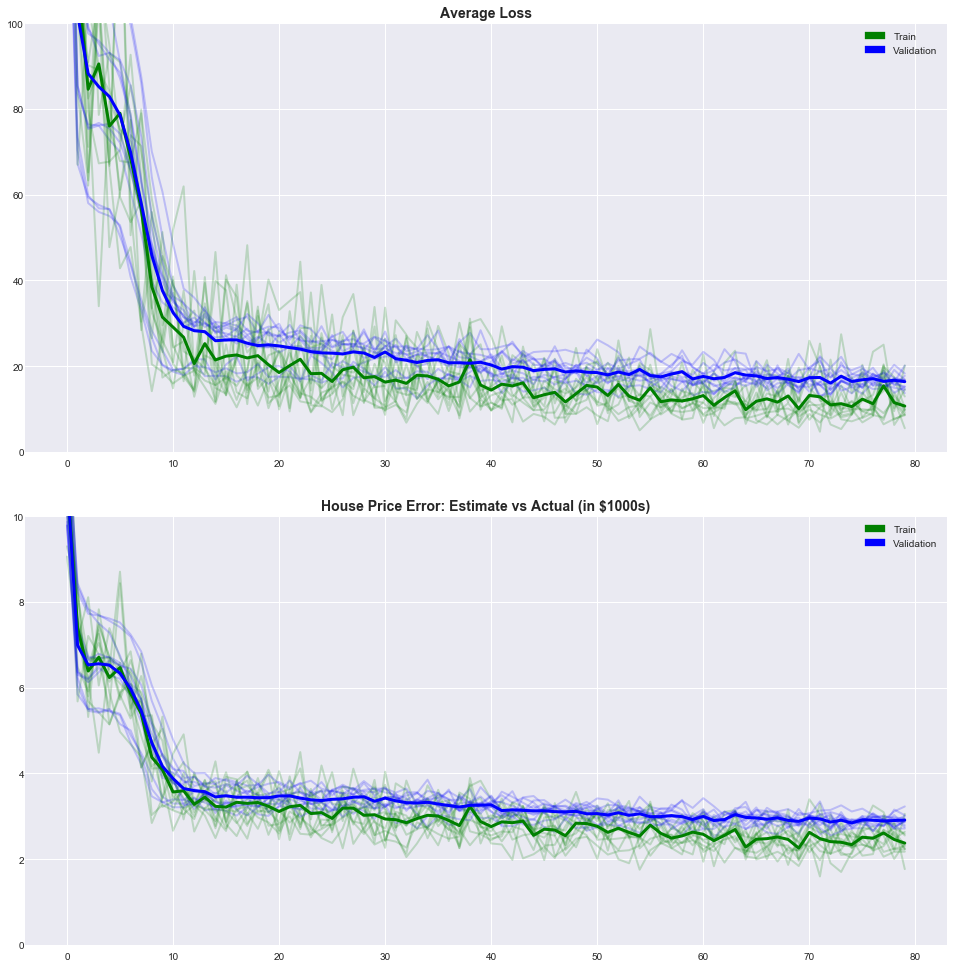

In [21]:
import matplotlib.patches as mpatches

# join the x and y together for shuffling
y_train = y_train.reshape((y_train.shape[0],1))
data = np.hstack([x_train, y_train])

# Make random generation repeatable
seed = 7
np.random.seed(seed)

# small dataset, shuffling and folding the data
shuff_count, i = 3, 0
split_count = 4
epoch_count = 80
b = 0

# Fit a scaling function to the train data
scale = p.StandardScaler().fit(x_train)

# Plotting Parameters #####################
subplot = ['Mean Absolute Error', 'Loss'] * 2
metrics = ['mean_absolute_error', 'loss', 'val_mean_absolute_error', 'val_loss']
legends = ['Train', 'Train', 'Validation', 'Validation']

history_set = {metric: np.zeros(shape=(epoch_count, shuff_count * split_count)) for metric in metrics}

plotter = plot_handler(2, 1)
plotter.add_plot(top=0,bottom=1,left=0,right=1, 
                 name='Loss', 
                 title='Average Loss')
plotter.add_plot(top=1,bottom=2, left=0, right=1, 
                 name='Mean Absolute Error',
                 title='House Price Error: Estimate vs Actual (in $1000s)')
############################################

best_model = NeuralNetwork(input_dim=x_train.shape[1], units=64)  # base_model()

while i < shuff_count:
    i += 1
    data_folds = mdl.KFold(n_splits=split_count, 
                           shuffle=True, 
                           random_state=seed).split(data)
    
    for dfold in data_folds:
        train, valid = dfold
        
        # Seperate each k fold of train data into a train and validation set
        xt = scale.transform(data[train,:-1])
        yt = data[train,-1:]

        # Transform validation set based on scaling on training set
        xv = scale.transform(data[valid,:-1])
        yv = data[valid,-1:]

        model = NeuralNetwork(input_dim=x_train.shape[1], units=64)  # base_model()
        history = model.fit(xt, yt, validation_data=(xv, yv), epochs=epoch_count)
        
        for m in metrics:
            # history_set[m][:, b] = history.history[m]
            history_set[m][:, b] = history[m]

        for metric, plot in zip(metrics, subplot):
            color = 'blue' if  metric[:3] == 'val' else 'green'
            plotter.ax[plot].plot(history[metric], 
                                  c=color, 
                                  linewidth=2,
                                  alpha=0.2)
        
        # Evaluate each model, keep the best one
        curr_evaluation = model.evaluate(scale.transform(x_test), y_test)  #, verbose=0)
        best_evaluation = best_model.evaluate(scale.transform(x_test), y_test)  #, verbose=0)
        
        if curr_evaluation[1] < best_evaluation[1]:
            best_model = model
            
        b += 1

# Plot average of all folds
for metric, plot in zip(metrics, subplot):
    color = 'blue' if metric[:3] == 'val' else 'green'
    plotter.ax[plot].plot(np.mean(history_set[metric], axis=1),
                          c=color,
                          linewidth=3,
                          alpha=1.0)
    
# Add Legend
train = mpatches.Patch(color='green', label='Train')
valid = mpatches.Patch(color='blue', label='Validation')

for plot in subplot[:2]:
    plotter.ax[plot].legend(handles=[train, valid])

plotter.ax['Loss'].set_ylim([0,100])
plotter.ax['Mean Absolute Error'].set_ylim([0,10])

plotter()

### Notes:

The faded lines show each training session on a unique instantiation of a model. The model's absolute mean error is recorded at the end of each epoch, and the change in loss and mean absolute error is plotted over each epoch. A new model is created and trained on a new partition of shuffled data and is subsequently plotted.

All these training sessions are then averaged together to get a representation of the training and validation loss and mean absolute error.


In [18]:
print('Base Model mean absolute error on test results: $', end='')
mse = np.mean(np.absolute((best_model.predict(scale.transform(x_test)) - y_test[:, None])), axis=0)
print(round(mse[0] * 1000,2))

Base Model mean absolute error on test results: $3369.93


In [ ]:
from keras import backend as K

# Some memory clean-up
K.clear_session()